In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# data=pd.read_csv('/Users/joohyunyoon/Downloads/Complete Project code/mnist_dataset.csv', error_bad_lines=False)
data=pd.read_csv('/Users/joohyunyoon/workspace/Complete Project code/mnist_dataset.csv')

In [29]:
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# data.drop(['pixel784'],axis=1,inplace=True)
# data.shape

In [31]:
data=data[:21000]

In [32]:
image=data.iloc[18]
image=np.array(image).astype('float32')
image=np.reshape(image, (28,28))
image=image/255
#scaling between 0-1
# 0.4862745  0.99215686 1.         0.24705882
# print(image.shape)
print(image)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

In [33]:
%matplotlib inline

In [34]:
image.shape

(28, 28)

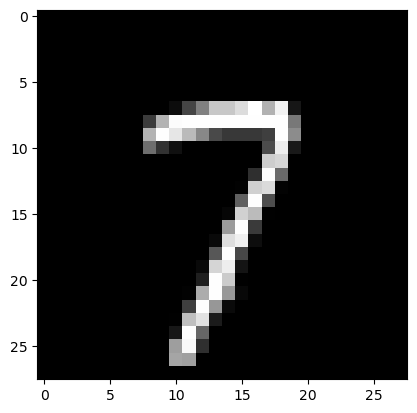

In [35]:
plt.imshow(image, cmap='gray')

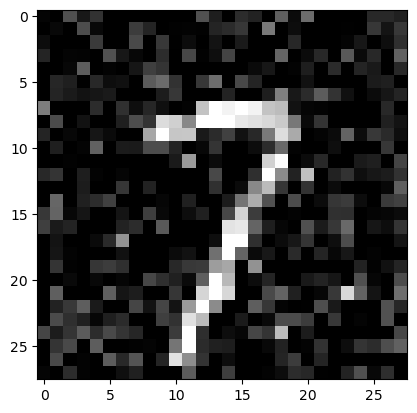

In [36]:
# put normal image into noisy image in order to create noisy image
noisy_image=image+0.2*np.random.randn(*image.shape) #image.shape is (28,28)
noisy_image=np.clip(noisy_image,0,1) #clip the image range between 0 and 1
plt.imshow(noisy_image, cmap='gray')

Data Preparation

In [37]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

In [38]:
class MNIST_AE_Dataset(Dataset):
    def __init__(self, csv_file, noise_factor=0.2, transform=None):
        self.data=pd.read_csv(csv_file)
        self.noise_factor=noise_factor
        self.transform=transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img=self.data.iloc[idx]
        img=np.array(img)
        img=np.reshape(img,(28,28,1)) /255 #height, width, channel
        
        noisy_img=img+self.noise_factor*np.random.randn(*img.shape)
        noisy_img=np.clip(noisy_img, 0,1)
        
        sample=(noisy_img, img)
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample

In [39]:
# ToTensorForAE : convert numpy image to torch tensor, convert image to pytorch model
# ex) image (28,28,1)->(1,28,28)

In [40]:
trainset=MNIST_AE_Dataset('/Users/joohyunyoon/workspace/Complete Project code/mnist_dataset.csv', transform=ToTensorForAE())
#shape is (1,1)

In [41]:
noisy_img, org_img=trainset[32]

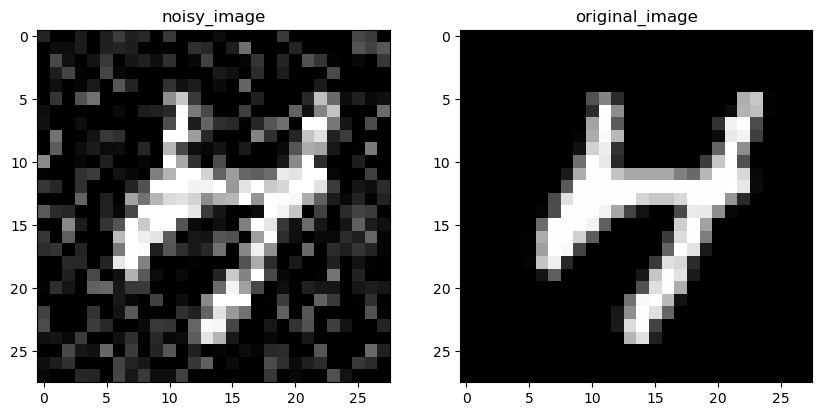

In [42]:
show_image(noisy_img, org_img)

In [43]:
from torch.utils.data import DataLoader

In [44]:
trainloader=DataLoader(trainset, batch_size=160, shuffle=True)
# trainset has (noisy_img, img)

In [45]:
dataiter=iter(trainloader) #An iterable-style dataset is an instance of a subclass of IterableDataset that implements the __iter__() protocol, and represents an iterable over data samples.
noisy_img, org_img=dataiter.next()
print(noisy_image.shape) #what I declare
print(org_img.shape) #16 images(batch size), 1 channel, 
print('batch num is {}'.format(len(trainloader)))
print('examples num is {}'.format(len(trainloader.dataset))) #same len as raw data

(28, 28)
torch.Size([160, 1, 28, 28])
batch num is 263
examples num is 42000


In [46]:
import torch
from torch import nn

In [47]:
#image=(h,w,c) or (h,w,d)
#h, w=pixel
#channel=depth=how many color, 0~255, black is 1
#color image has 3channel, red, green, blue
#kernel_size can be customozed, normally (3,3) or (5,5)

def Encoder():
    enc=nn.Sequential(
        
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    
    )
    
    return enc

In [48]:
def Decoder():
    dec=nn.Sequential(
        
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(2,2), stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(2,2), stride=2),
        nn.Sigmoid() #Used in Binary Classification. 
        #Used in output layer usually. 
        #if output closes to 0 or 1, gradient is very close to 0
        
    )
    
    return dec

In [49]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder=Encoder()
        self.decoder=Decoder()
        
    def forward(self, inp_imgs):
        encoder_out=self.encoder(inp_imgs)
        decoder_out=self.decoder(encoder_out)
        
        return decoder_out
model=AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [50]:
model.parameters()

<generator object Module.parameters at 0x7fa4d6cf8900>

In [51]:
from tqdm import tqdm

optimizer=torch.optim.Adam(model.parameters(), lr=0.001) #it has w and b
criterion=nn.MSELoss() #Mean Squared Error
epochs=10

In [52]:
for i in range(epochs):
    train_loss=0.0
    
    model.train()

    for batch in tqdm(trainloader): # 2625batches
        noisy_img, org_img=batch
        
        cleaned_img=model(noisy_img)
        print(cleaned_img.shape)
        loss=criterion(cleaned_img, org_img)
        #a criterion that measures the mean squared error (squared L2 norm) 
        #between each element in the input x and target y.
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item() #It returns the value of this tensor
    avg_train_loss=train_loss/len(trainloader)
    print('epoches : {} train loss {}'.format(i+1, avg_train_loss))
              

  1%|          | 2/263 [00:00<00:17, 14.58it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 4/263 [00:00<00:17, 14.56it/s]

torch.Size([160, 1, 28, 28])


  2%|▏         | 6/263 [00:00<00:17, 14.52it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  4%|▍         | 10/263 [00:00<00:17, 14.82it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▌         | 14/263 [00:00<00:16, 14.69it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  7%|▋         | 18/263 [00:01<00:16, 14.72it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 20/263 [00:01<00:16, 14.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  9%|▉         | 24/263 [00:01<00:16, 14.87it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█         | 28/263 [00:01<00:15, 15.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 12%|█▏        | 32/263 [00:02<00:16, 14.02it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▎        | 36/263 [00:02<00:16, 13.72it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▍        | 38/263 [00:02<00:16, 13.48it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▌        | 42/263 [00:02<00:16, 13.57it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 44/263 [00:03<00:15, 13.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 18%|█▊        | 48/263 [00:03<00:15, 14.10it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 19%|█▉        | 50/263 [00:03<00:15, 13.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██        | 54/263 [00:03<00:14, 14.32it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 58/263 [00:04<00:14, 14.01it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 23%|██▎       | 60/263 [00:04<00:14, 13.87it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 24%|██▍       | 64/263 [00:04<00:14, 14.10it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 26%|██▌       | 68/263 [00:04<00:13, 14.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 70/263 [00:04<00:13, 14.18it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 28%|██▊       | 74/263 [00:05<00:13, 14.53it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 30%|██▉       | 78/263 [00:05<00:13, 13.93it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 30%|███       | 80/263 [00:05<00:13, 13.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 32%|███▏      | 84/263 [00:05<00:12, 13.91it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 33%|███▎      | 86/263 [00:06<00:13, 13.46it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 34%|███▍      | 90/263 [00:06<00:12, 13.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 35%|███▍      | 92/263 [00:06<00:12, 13.59it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 96/263 [00:06<00:12, 13.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 98/263 [00:06<00:12, 13.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 39%|███▉      | 102/263 [00:07<00:12, 12.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|███▉      | 104/263 [00:07<00:12, 12.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 41%|████      | 108/263 [00:07<00:11, 13.94it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 112/263 [00:07<00:10, 14.55it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 114/263 [00:08<00:10, 13.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 45%|████▍     | 118/263 [00:08<00:10, 13.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▌     | 120/263 [00:08<00:10, 13.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▋     | 122/263 [00:08<00:11, 12.77it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 126/263 [00:09<00:11, 11.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 49%|████▉     | 130/263 [00:09<00:10, 12.19it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 50%|█████     | 132/263 [00:09<00:10, 12.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 52%|█████▏    | 136/263 [00:09<00:10, 12.43it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 52%|█████▏    | 138/263 [00:10<00:09, 12.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▍    | 142/263 [00:10<00:09, 12.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 55%|█████▍    | 144/263 [00:10<00:09, 12.90it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 56%|█████▋    | 148/263 [00:10<00:08, 14.03it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 58%|█████▊    | 152/263 [00:11<00:08, 13.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 59%|█████▊    | 154/263 [00:11<00:07, 14.03it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|██████    | 158/263 [00:11<00:07, 14.64it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 62%|██████▏   | 162/263 [00:11<00:06, 14.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 166/263 [00:12<00:06, 14.61it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 65%|██████▍   | 170/263 [00:12<00:06, 14.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 65%|██████▌   | 172/263 [00:12<00:06, 14.67it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 67%|██████▋   | 176/263 [00:12<00:06, 14.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 68%|██████▊   | 178/263 [00:12<00:05, 14.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 69%|██████▉   | 182/263 [00:13<00:05, 14.31it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|██████▉   | 184/263 [00:13<00:05, 14.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 71%|███████▏  | 188/263 [00:13<00:05, 14.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 72%|███████▏  | 190/263 [00:13<00:05, 14.49it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 74%|███████▍  | 194/263 [00:13<00:04, 14.72it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▌  | 198/263 [00:14<00:04, 14.70it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 77%|███████▋  | 202/263 [00:14<00:04, 14.83it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 78%|███████▊  | 204/263 [00:14<00:04, 14.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▉  | 208/263 [00:14<00:03, 14.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 80%|███████▉  | 210/263 [00:15<00:03, 14.08it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 81%|████████▏ | 214/263 [00:15<00:03, 14.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 82%|████████▏ | 216/263 [00:15<00:03, 14.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▎ | 220/263 [00:15<00:03, 13.41it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▍ | 222/263 [00:15<00:03, 13.51it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▌ | 226/263 [00:16<00:02, 13.70it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 228/263 [00:16<00:02, 13.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 88%|████████▊ | 232/263 [00:16<00:02, 14.54it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 90%|████████▉ | 236/263 [00:16<00:01, 14.68it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 91%|█████████▏| 240/263 [00:17<00:01, 14.94it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 93%|█████████▎| 244/263 [00:17<00:01, 14.50it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 94%|█████████▎| 246/263 [00:17<00:01, 14.58it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▌| 250/263 [00:17<00:00, 14.39it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 96%|█████████▌| 252/263 [00:18<00:00, 13.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 97%|█████████▋| 256/263 [00:18<00:00, 14.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 258/263 [00:18<00:00, 14.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|█████████▉| 262/263 [00:18<00:00, 14.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([80, 1, 28, 28])


100%|██████████| 263/263 [00:18<00:00, 13.99it/s]


epoches : 1 train loss 0.07389416786427734


  1%|          | 2/263 [00:00<00:19, 13.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 4/263 [00:00<00:19, 13.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 6/263 [00:00<00:18, 13.90it/s]

torch.Size([160, 1, 28, 28])


  3%|▎         | 8/263 [00:00<00:17, 14.38it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▍         | 12/263 [00:00<00:16, 14.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  6%|▌         | 16/263 [00:01<00:16, 14.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 20/263 [00:01<00:16, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  9%|▉         | 24/263 [00:01<00:15, 14.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 10%|▉         | 26/263 [00:01<00:15, 15.08it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█         | 28/263 [00:01<00:15, 15.00it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█▏        | 30/263 [00:02<00:15, 15.11it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 12%|█▏        | 32/263 [00:02<00:15, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 34/263 [00:02<00:15, 15.06it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▎        | 36/263 [00:02<00:15, 15.06it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▍        | 38/263 [00:02<00:14, 15.10it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 15%|█▌        | 40/263 [00:02<00:14, 15.12it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▌        | 42/263 [00:02<00:14, 15.13it/s]

torch.Size([160, 1, 28, 28])


 17%|█▋        | 44/263 [00:02<00:14, 14.82it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 46/263 [00:03<00:14, 14.88it/s]

torch.Size([160, 1, 28, 28])


 18%|█▊        | 48/263 [00:03<00:14, 14.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 20%|█▉        | 52/263 [00:03<00:14, 14.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██▏       | 56/263 [00:03<00:15, 13.77it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 58/263 [00:03<00:14, 14.15it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 24%|██▎       | 62/263 [00:04<00:13, 14.87it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 25%|██▌       | 66/263 [00:04<00:13, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 26%|██▌       | 68/263 [00:04<00:14, 13.12it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 72/263 [00:04<00:13, 13.67it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 29%|██▉       | 76/263 [00:05<00:13, 14.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 30%|███       | 80/263 [00:05<00:13, 13.66it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 32%|███▏      | 84/263 [00:05<00:12, 14.40it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 33%|███▎      | 88/263 [00:06<00:11, 14.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 35%|███▍      | 92/263 [00:06<00:11, 14.90it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 96/263 [00:06<00:11, 15.17it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 38%|███▊      | 100/263 [00:06<00:10, 15.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|███▉      | 104/263 [00:07<00:10, 15.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 41%|████      | 108/263 [00:07<00:10, 15.42it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 112/263 [00:07<00:09, 15.41it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 44%|████▍     | 116/263 [00:07<00:09, 15.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▌     | 120/263 [00:08<00:09, 15.50it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 47%|████▋     | 124/263 [00:08<00:08, 15.58it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 49%|████▊     | 128/263 [00:08<00:08, 15.45it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 50%|█████     | 132/263 [00:08<00:09, 14.53it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████     | 134/263 [00:09<00:09, 14.17it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 52%|█████▏    | 138/263 [00:09<00:08, 14.40it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 53%|█████▎    | 140/263 [00:09<00:08, 14.38it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 55%|█████▍    | 144/263 [00:09<00:08, 14.64it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 56%|█████▌    | 146/263 [00:09<00:07, 14.68it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 150/263 [00:10<00:07, 14.60it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 58%|█████▊    | 152/263 [00:10<00:07, 14.74it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 59%|█████▉    | 156/263 [00:10<00:07, 14.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 61%|██████    | 160/263 [00:10<00:06, 15.04it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 62%|██████▏   | 164/263 [00:11<00:06, 14.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 64%|██████▍   | 168/263 [00:11<00:06, 14.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 65%|██████▍   | 170/263 [00:11<00:06, 14.60it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 66%|██████▌   | 174/263 [00:11<00:05, 14.89it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 68%|██████▊   | 178/263 [00:12<00:05, 14.89it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 69%|██████▉   | 182/263 [00:12<00:05, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 71%|███████   | 186/263 [00:12<00:05, 15.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 72%|███████▏  | 190/263 [00:12<00:04, 15.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 74%|███████▍  | 194/263 [00:13<00:04, 15.43it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▌  | 198/263 [00:13<00:04, 14.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 77%|███████▋  | 202/263 [00:13<00:04, 14.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 78%|███████▊  | 204/263 [00:13<00:04, 14.53it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▉  | 208/263 [00:14<00:03, 14.89it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 81%|████████  | 212/263 [00:14<00:03, 14.91it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 82%|████████▏ | 216/263 [00:14<00:03, 15.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▎ | 220/263 [00:14<00:02, 15.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 85%|████████▌ | 224/263 [00:15<00:02, 15.32it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 228/263 [00:15<00:02, 15.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 88%|████████▊ | 232/263 [00:15<00:02, 15.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 90%|████████▉ | 236/263 [00:15<00:01, 15.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 91%|█████████▏| 240/263 [00:16<00:01, 15.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 93%|█████████▎| 244/263 [00:16<00:01, 15.01it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 94%|█████████▍| 248/263 [00:16<00:01, 14.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▌| 250/263 [00:16<00:00, 14.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 97%|█████████▋| 254/263 [00:17<00:00, 14.64it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 258/263 [00:17<00:00, 14.69it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|██████████| 263/263 [00:17<00:00, 14.86it/s]


torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([80, 1, 28, 28])
epoches : 2 train loss 0.011336010611640863


  0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([160, 1, 28, 28])


  1%|          | 3/263 [00:00<00:19, 13.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 5/263 [00:00<00:18, 14.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  3%|▎         | 7/263 [00:00<00:17, 14.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  3%|▎         | 9/263 [00:00<00:17, 14.62it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  4%|▍         | 11/263 [00:00<00:17, 14.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▍         | 13/263 [00:00<00:16, 14.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  6%|▌         | 15/263 [00:01<00:16, 14.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  6%|▋         | 17/263 [00:01<00:16, 14.64it/s]

torch.Size([160, 1, 28, 28])


  7%|▋         | 19/263 [00:01<00:16, 14.52it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 21/263 [00:01<00:16, 14.51it/s]

torch.Size([160, 1, 28, 28])


  9%|▊         | 23/263 [00:01<00:16, 14.66it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 10%|▉         | 25/263 [00:01<00:16, 14.69it/s]

torch.Size([160, 1, 28, 28])


 10%|█         | 27/263 [00:01<00:16, 14.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█         | 29/263 [00:02<00:16, 14.52it/s]

torch.Size([160, 1, 28, 28])


 12%|█▏        | 31/263 [00:02<00:15, 14.61it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 33/263 [00:02<00:15, 14.69it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 35/263 [00:02<00:15, 14.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▍        | 37/263 [00:02<00:15, 14.91it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 15%|█▍        | 39/263 [00:02<00:15, 14.89it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▌        | 41/263 [00:02<00:14, 14.93it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▋        | 43/263 [00:02<00:14, 14.92it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 45/263 [00:03<00:14, 14.96it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 18%|█▊        | 47/263 [00:03<00:14, 14.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 19%|█▊        | 49/263 [00:03<00:14, 15.05it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 19%|█▉        | 51/263 [00:03<00:14, 14.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 20%|██        | 53/263 [00:03<00:14, 14.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██        | 55/263 [00:03<00:13, 14.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 57/263 [00:03<00:13, 14.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 59/263 [00:04<00:13, 14.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 23%|██▎       | 61/263 [00:04<00:13, 15.01it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 24%|██▍       | 63/263 [00:04<00:13, 15.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 25%|██▍       | 65/263 [00:04<00:13, 15.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 25%|██▌       | 67/263 [00:04<00:13, 14.92it/s]

torch.Size([160, 1, 28, 28])


 26%|██▌       | 69/263 [00:04<00:13, 13.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 71/263 [00:04<00:13, 13.86it/s]

torch.Size([160, 1, 28, 28])


 28%|██▊       | 73/263 [00:04<00:13, 14.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 29%|██▊       | 75/263 [00:05<00:13, 14.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 29%|██▉       | 77/263 [00:05<00:12, 14.59it/s]

torch.Size([160, 1, 28, 28])


 30%|███       | 79/263 [00:05<00:12, 14.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 31%|███       | 81/263 [00:05<00:15, 11.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 32%|███▏      | 83/263 [00:05<00:16, 10.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 32%|███▏      | 85/263 [00:06<00:17, 10.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 33%|███▎      | 87/263 [00:06<00:17,  9.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 34%|███▍      | 90/263 [00:06<00:18,  9.59it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 35%|███▍      | 92/263 [00:06<00:18,  9.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 36%|███▌      | 94/263 [00:07<00:17,  9.43it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 96/263 [00:07<00:18,  9.12it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 98/263 [00:07<00:18,  8.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 38%|███▊      | 100/263 [00:07<00:18,  8.65it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 39%|███▉      | 102/263 [00:07<00:18,  8.68it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|███▉      | 104/263 [00:08<00:17,  8.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|████      | 106/263 [00:08<00:17,  9.12it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 41%|████      | 108/263 [00:08<00:17,  9.00it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 42%|████▏     | 110/263 [00:08<00:16,  9.17it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 112/263 [00:09<00:16,  9.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 114/263 [00:09<00:16,  9.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 44%|████▍     | 116/263 [00:09<00:15,  9.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 45%|████▍     | 118/263 [00:09<00:15,  9.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▌     | 120/263 [00:09<00:16,  8.61it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▋     | 122/263 [00:10<00:16,  8.31it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 125/263 [00:10<00:13, 10.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 127/263 [00:10<00:14,  9.67it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 49%|████▉     | 129/263 [00:10<00:13, 10.11it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████     | 133/263 [00:11<00:11, 10.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████▏    | 135/263 [00:11<00:11, 11.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 53%|█████▎    | 139/263 [00:11<00:10, 12.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▎    | 141/263 [00:11<00:09, 12.70it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▍    | 143/263 [00:11<00:09, 13.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 56%|█████▌    | 147/263 [00:12<00:10, 11.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 151/263 [00:12<00:08, 12.55it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 58%|█████▊    | 153/263 [00:12<00:08, 12.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|█████▉    | 157/263 [00:13<00:07, 13.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|██████    | 159/263 [00:13<00:07, 13.93it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 62%|██████▏   | 163/263 [00:13<00:07, 12.94it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 165/263 [00:13<00:08, 10.92it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 167/263 [00:13<00:08, 11.73it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 65%|██████▌   | 171/263 [00:14<00:06, 13.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 67%|██████▋   | 175/263 [00:14<00:06, 14.19it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 68%|██████▊   | 179/263 [00:14<00:05, 14.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|██████▉   | 183/263 [00:15<00:05, 14.12it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|███████   | 185/263 [00:15<00:05, 13.56it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 72%|███████▏  | 189/263 [00:15<00:05, 13.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 191/263 [00:15<00:05, 13.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 74%|███████▍  | 195/263 [00:15<00:05, 12.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▍  | 197/263 [00:16<00:05, 12.56it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 76%|███████▋  | 201/263 [00:16<00:04, 13.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 77%|███████▋  | 203/263 [00:16<00:04, 13.64it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▊  | 207/263 [00:16<00:03, 14.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 80%|████████  | 211/263 [00:17<00:03, 14.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 81%|████████  | 213/263 [00:17<00:03, 13.61it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 83%|████████▎ | 217/263 [00:17<00:03, 14.40it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▍ | 221/263 [00:17<00:02, 14.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 85%|████████▍ | 223/263 [00:17<00:02, 14.52it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▋ | 227/263 [00:18<00:02, 14.12it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 229/263 [00:18<00:02, 14.05it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▊ | 233/263 [00:18<00:02, 13.83it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▉ | 235/263 [00:18<00:01, 14.17it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 91%|█████████ | 239/263 [00:19<00:01, 14.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 92%|█████████▏| 243/263 [00:19<00:01, 14.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 94%|█████████▍| 247/263 [00:19<00:01, 14.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▍| 249/263 [00:19<00:01, 13.67it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 96%|█████████▌| 253/263 [00:20<00:00, 11.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 97%|█████████▋| 255/263 [00:20<00:00, 12.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 259/263 [00:20<00:00, 12.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 99%|█████████▉| 261/263 [00:20<00:00, 12.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|██████████| 263/263 [00:20<00:00, 12.53it/s]


torch.Size([80, 1, 28, 28])
epoches : 3 train loss 0.008076512906346258


  1%|          | 2/263 [00:00<00:20, 12.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 4/263 [00:00<00:20, 12.68it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 6/263 [00:00<00:20, 12.83it/s]

torch.Size([160, 1, 28, 28])


  3%|▎         | 8/263 [00:00<00:19, 12.82it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  4%|▍         | 10/263 [00:00<00:20, 12.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▍         | 12/263 [00:00<00:19, 12.90it/s]

torch.Size([160, 1, 28, 28])


  5%|▌         | 14/263 [00:01<00:18, 13.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  6%|▌         | 16/263 [00:01<00:19, 12.94it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  7%|▋         | 18/263 [00:01<00:19, 12.79it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 20/263 [00:01<00:22, 11.03it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 22/263 [00:01<00:26,  9.04it/s]

torch.Size([160, 1, 28, 28])


  9%|▊         | 23/263 [00:02<00:27,  8.61it/s]

torch.Size([160, 1, 28, 28])


  9%|▉         | 24/263 [00:02<00:31,  7.70it/s]

torch.Size([160, 1, 28, 28])


 10%|▉         | 25/263 [00:02<00:33,  7.06it/s]

torch.Size([160, 1, 28, 28])


 11%|█         | 28/263 [00:03<00:40,  5.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█▏        | 30/263 [00:03<00:37,  6.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 12%|█▏        | 32/263 [00:03<00:34,  6.68it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 34/263 [00:03<00:30,  7.56it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▎        | 36/263 [00:04<00:28,  7.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▍        | 37/263 [00:04<00:29,  7.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 15%|█▌        | 40/263 [00:04<00:30,  7.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▌        | 42/263 [00:05<00:29,  7.53it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 44/263 [00:05<00:27,  7.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 46/263 [00:05<00:27,  7.94it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 18%|█▊        | 48/263 [00:05<00:26,  8.00it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 19%|█▉        | 50/263 [00:06<00:27,  7.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 20%|█▉        | 52/263 [00:06<00:26,  7.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██        | 54/263 [00:06<00:25,  8.31it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██▏       | 56/263 [00:06<00:24,  8.51it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 58/263 [00:06<00:24,  8.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 23%|██▎       | 60/263 [00:07<00:23,  8.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 24%|██▍       | 63/263 [00:07<00:20,  9.57it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 25%|██▍       | 65/263 [00:07<00:18, 10.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 26%|██▌       | 69/263 [00:07<00:15, 12.52it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 71/263 [00:08<00:14, 13.08it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 29%|██▊       | 75/263 [00:08<00:14, 13.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 29%|██▉       | 77/263 [00:08<00:13, 13.38it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 31%|███       | 81/263 [00:08<00:13, 13.77it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 32%|███▏      | 83/263 [00:08<00:13, 13.74it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 33%|███▎      | 87/263 [00:09<00:12, 14.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 35%|███▍      | 91/263 [00:09<00:12, 14.14it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 35%|███▌      | 93/263 [00:09<00:12, 13.79it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 97/263 [00:09<00:11, 14.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 38%|███▊      | 99/263 [00:10<00:11, 14.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 39%|███▉      | 103/263 [00:10<00:11, 13.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|███▉      | 105/263 [00:10<00:11, 13.56it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 41%|████▏     | 109/263 [00:10<00:11, 13.72it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 42%|████▏     | 111/263 [00:10<00:10, 13.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 44%|████▎     | 115/263 [00:11<00:10, 14.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 44%|████▍     | 117/263 [00:11<00:10, 14.15it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▌     | 121/263 [00:11<00:09, 14.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 47%|████▋     | 123/263 [00:11<00:09, 14.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 127/263 [00:12<00:09, 14.41it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 49%|████▉     | 129/263 [00:12<00:09, 14.42it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████     | 133/263 [00:12<00:09, 14.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████▏    | 135/263 [00:12<00:08, 14.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 53%|█████▎    | 139/263 [00:12<00:08, 14.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▎    | 141/263 [00:13<00:08, 14.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 55%|█████▌    | 145/263 [00:13<00:08, 13.67it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 56%|█████▌    | 147/263 [00:13<00:08, 13.55it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 151/263 [00:13<00:08, 13.83it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 58%|█████▊    | 153/263 [00:13<00:07, 13.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|█████▉    | 157/263 [00:14<00:07, 14.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|██████    | 159/263 [00:14<00:07, 14.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 62%|██████▏   | 163/263 [00:14<00:06, 14.39it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 165/263 [00:14<00:06, 14.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 64%|██████▍   | 169/263 [00:15<00:06, 14.32it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 65%|██████▌   | 171/263 [00:15<00:06, 14.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 67%|██████▋   | 175/263 [00:15<00:06, 14.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 67%|██████▋   | 177/263 [00:15<00:05, 14.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 69%|██████▉   | 181/263 [00:15<00:05, 14.52it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|███████   | 185/263 [00:16<00:05, 14.62it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 72%|███████▏  | 189/263 [00:16<00:05, 14.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 193/263 [00:16<00:04, 14.57it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 74%|███████▍  | 195/263 [00:16<00:04, 14.54it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 76%|███████▌  | 199/263 [00:17<00:04, 14.60it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 76%|███████▋  | 201/263 [00:17<00:04, 14.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 78%|███████▊  | 205/263 [00:17<00:04, 14.43it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▊  | 207/263 [00:17<00:03, 14.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 80%|████████  | 211/263 [00:17<00:03, 14.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 81%|████████  | 213/263 [00:18<00:03, 14.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 83%|████████▎ | 217/263 [00:18<00:03, 14.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 83%|████████▎ | 219/263 [00:18<00:03, 14.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 85%|████████▍ | 223/263 [00:18<00:02, 14.45it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▌ | 225/263 [00:18<00:02, 14.51it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 229/263 [00:19<00:02, 14.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 88%|████████▊ | 231/263 [00:19<00:02, 14.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▉ | 235/263 [00:19<00:01, 14.50it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 90%|█████████ | 237/263 [00:19<00:01, 14.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 92%|█████████▏| 241/263 [00:20<00:01, 14.48it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 92%|█████████▏| 243/263 [00:20<00:01, 14.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 94%|█████████▍| 247/263 [00:20<00:01, 14.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▍| 249/263 [00:20<00:00, 14.46it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 96%|█████████▌| 253/263 [00:20<00:00, 14.50it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 97%|█████████▋| 255/263 [00:20<00:00, 14.49it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 259/263 [00:21<00:00, 14.50it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|██████████| 263/263 [00:21<00:00, 12.23it/s]


torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([80, 1, 28, 28])
epoches : 4 train loss 0.007075203364863708


  1%|          | 2/263 [00:00<00:17, 14.66it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 6/263 [00:00<00:17, 14.68it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  4%|▍         | 10/263 [00:00<00:17, 14.57it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▍         | 12/263 [00:00<00:17, 14.46it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▌         | 14/263 [00:01<00:19, 12.59it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  6%|▌         | 16/263 [00:01<00:21, 11.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  7%|▋         | 18/263 [00:01<00:23, 10.42it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 20/263 [00:01<00:24,  9.91it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  9%|▊         | 23/263 [00:02<00:27,  8.68it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 10%|▉         | 25/263 [00:02<00:27,  8.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 10%|█         | 27/263 [00:02<00:26,  8.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█         | 29/263 [00:02<00:26,  8.82it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 12%|█▏        | 31/263 [00:03<00:26,  8.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 33/263 [00:03<00:25,  8.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 35/263 [00:03<00:25,  8.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▍        | 37/263 [00:03<00:27,  8.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 15%|█▍        | 39/263 [00:03<00:27,  8.17it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▌        | 41/263 [00:04<00:26,  8.38it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▋        | 43/263 [00:04<00:25,  8.66it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 45/263 [00:04<00:25,  8.60it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 18%|█▊        | 47/263 [00:04<00:24,  8.81it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 19%|█▊        | 49/263 [00:05<00:24,  8.86it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 19%|█▉        | 51/263 [00:05<00:23,  8.86it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 20%|██        | 53/263 [00:05<00:23,  8.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██        | 55/263 [00:05<00:23,  8.77it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 57/263 [00:06<00:23,  8.81it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 59/263 [00:06<00:23,  8.81it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 23%|██▎       | 61/263 [00:06<00:22,  8.83it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 24%|██▍       | 63/263 [00:06<00:22,  8.91it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 25%|██▌       | 66/263 [00:06<00:19, 10.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 26%|██▌       | 68/263 [00:07<00:16, 11.49it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 72/263 [00:07<00:14, 13.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 28%|██▊       | 74/263 [00:07<00:14, 13.46it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 30%|██▉       | 78/263 [00:07<00:13, 13.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 30%|███       | 80/263 [00:07<00:13, 14.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 32%|███▏      | 84/263 [00:08<00:12, 14.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 33%|███▎      | 86/263 [00:08<00:12, 14.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 34%|███▍      | 90/263 [00:08<00:12, 14.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 35%|███▍      | 92/263 [00:08<00:11, 14.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 96/263 [00:09<00:11, 14.40it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 98/263 [00:09<00:11, 14.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 39%|███▉      | 102/263 [00:09<00:11, 14.53it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|███▉      | 104/263 [00:09<00:10, 14.54it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 41%|████      | 108/263 [00:09<00:10, 14.45it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 42%|████▏     | 110/263 [00:10<00:10, 14.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 114/263 [00:10<00:10, 14.49it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 44%|████▍     | 116/263 [00:10<00:10, 14.41it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▌     | 120/263 [00:10<00:10, 14.17it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▋     | 122/263 [00:10<00:09, 14.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 126/263 [00:11<00:09, 14.40it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 49%|████▊     | 128/263 [00:11<00:09, 14.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 50%|█████     | 132/263 [00:11<00:08, 14.58it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████     | 134/263 [00:11<00:08, 14.57it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 52%|█████▏    | 138/263 [00:11<00:08, 14.48it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 53%|█████▎    | 140/263 [00:12<00:08, 14.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▍    | 142/263 [00:12<00:08, 14.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 56%|█████▌    | 146/263 [00:12<00:09, 12.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 150/263 [00:12<00:08, 13.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 58%|█████▊    | 152/263 [00:13<00:08, 13.32it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 59%|█████▉    | 156/263 [00:13<00:08, 13.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|██████    | 158/263 [00:13<00:07, 13.52it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 62%|██████▏   | 162/263 [00:13<00:07, 14.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 166/263 [00:14<00:06, 14.69it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 65%|██████▍   | 170/263 [00:14<00:06, 14.91it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 66%|██████▌   | 174/263 [00:14<00:05, 15.04it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 68%|██████▊   | 178/263 [00:14<00:05, 15.03it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 69%|██████▉   | 182/263 [00:15<00:05, 15.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 71%|███████   | 186/263 [00:15<00:05, 15.05it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 72%|███████▏  | 190/263 [00:15<00:05, 13.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 192/263 [00:15<00:05, 14.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▍  | 196/263 [00:16<00:04, 14.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▌  | 198/263 [00:16<00:04, 14.02it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 77%|███████▋  | 202/263 [00:16<00:04, 14.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 78%|███████▊  | 204/263 [00:16<00:04, 14.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▉  | 208/263 [00:16<00:03, 14.58it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 81%|████████  | 212/263 [00:17<00:03, 14.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 82%|████████▏ | 216/263 [00:17<00:03, 14.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▎ | 220/263 [00:17<00:02, 15.11it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 85%|████████▌ | 224/263 [00:17<00:02, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 228/263 [00:18<00:02, 15.12it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 88%|████████▊ | 232/263 [00:18<00:02, 14.92it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 90%|████████▉ | 236/263 [00:18<00:01, 14.93it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 91%|█████████▏| 240/263 [00:19<00:01, 15.08it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 93%|█████████▎| 244/263 [00:19<00:01, 15.10it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 94%|█████████▍| 248/263 [00:19<00:00, 15.12it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 96%|█████████▌| 252/263 [00:19<00:00, 15.17it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 97%|█████████▋| 256/263 [00:20<00:00, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 99%|█████████▉| 260/263 [00:20<00:00, 15.03it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|██████████| 263/263 [00:20<00:00, 12.81it/s]


torch.Size([80, 1, 28, 28])
epoches : 5 train loss 0.006563985493643202


  0%|          | 1/263 [00:00<00:30,  8.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  1%|          | 3/263 [00:00<00:21, 12.23it/s]

torch.Size([160, 1, 28, 28])


  2%|▏         | 5/263 [00:00<00:19, 13.38it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  3%|▎         | 7/263 [00:00<00:18, 13.67it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  4%|▍         | 11/263 [00:00<00:19, 12.94it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  6%|▌         | 15/263 [00:01<00:17, 14.08it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  7%|▋         | 19/263 [00:01<00:16, 14.70it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  9%|▊         | 23/263 [00:01<00:15, 15.00it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 10%|█         | 27/263 [00:01<00:15, 15.15it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 12%|█▏        | 31/263 [00:02<00:15, 15.18it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 35/263 [00:02<00:15, 15.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▍        | 37/263 [00:02<00:15, 14.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▌        | 41/263 [00:02<00:14, 15.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 45/263 [00:03<00:14, 15.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 19%|█▊        | 49/263 [00:03<00:14, 15.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 20%|██        | 53/263 [00:03<00:13, 15.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 57/263 [00:03<00:13, 15.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 23%|██▎       | 61/263 [00:04<00:13, 15.42it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 25%|██▍       | 65/263 [00:04<00:12, 15.42it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 26%|██▌       | 69/263 [00:04<00:12, 15.32it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 28%|██▊       | 73/263 [00:04<00:12, 15.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 29%|██▉       | 77/263 [00:05<00:12, 15.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 31%|███       | 81/263 [00:05<00:11, 15.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 32%|███▏      | 85/263 [00:05<00:11, 15.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 34%|███▍      | 89/263 [00:05<00:11, 15.15it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 35%|███▌      | 93/263 [00:06<00:11, 15.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 97/263 [00:06<00:10, 15.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 38%|███▊      | 101/263 [00:06<00:10, 15.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|███▉      | 105/263 [00:07<00:10, 15.41it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 41%|████▏     | 109/263 [00:07<00:10, 15.31it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 113/263 [00:07<00:09, 15.18it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 44%|████▍     | 117/263 [00:07<00:09, 15.18it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▌     | 121/263 [00:08<00:09, 15.19it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 125/263 [00:08<00:09, 15.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 49%|████▉     | 129/263 [00:08<00:08, 15.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████     | 133/263 [00:08<00:08, 15.39it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 52%|█████▏    | 137/263 [00:09<00:08, 15.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▎    | 141/263 [00:09<00:07, 15.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 55%|█████▌    | 145/263 [00:09<00:07, 15.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 149/263 [00:09<00:07, 15.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 58%|█████▊    | 153/263 [00:10<00:07, 15.10it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|█████▉    | 157/263 [00:10<00:07, 14.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 61%|██████    | 161/263 [00:10<00:06, 14.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 165/263 [00:10<00:06, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 64%|██████▍   | 169/263 [00:11<00:06, 15.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 66%|██████▌   | 173/263 [00:11<00:05, 15.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 67%|██████▋   | 177/263 [00:11<00:05, 15.18it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 69%|██████▉   | 181/263 [00:12<00:05, 15.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|███████   | 185/263 [00:12<00:05, 15.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 72%|███████▏  | 189/263 [00:12<00:04, 15.06it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 193/263 [00:12<00:04, 15.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▍  | 197/263 [00:13<00:04, 15.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 76%|███████▋  | 201/263 [00:13<00:04, 15.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 78%|███████▊  | 205/263 [00:13<00:03, 15.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▉  | 209/263 [00:13<00:03, 15.39it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 81%|████████  | 213/263 [00:14<00:03, 15.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 83%|████████▎ | 217/263 [00:14<00:03, 15.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▍ | 221/263 [00:14<00:02, 15.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▌ | 225/263 [00:14<00:02, 15.11it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 229/263 [00:15<00:02, 15.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▊ | 233/263 [00:15<00:01, 15.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 90%|█████████ | 237/263 [00:15<00:01, 15.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 92%|█████████▏| 241/263 [00:16<00:01, 13.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 93%|█████████▎| 245/263 [00:16<00:01, 14.46it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 94%|█████████▍| 247/263 [00:16<00:01, 13.39it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▍| 249/263 [00:16<00:01, 11.86it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▌| 251/263 [00:16<00:01, 10.99it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 96%|█████████▌| 253/263 [00:17<00:00, 10.45it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 97%|█████████▋| 255/263 [00:17<00:00, 10.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 257/263 [00:17<00:00,  9.92it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 99%|█████████▉| 260/263 [00:17<00:00,  9.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|██████████| 263/263 [00:18<00:00, 14.53it/s]


torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([80, 1, 28, 28])
epoches : 6 train loss 0.006238650337584005


  1%|          | 2/263 [00:00<00:29,  8.84it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 4/263 [00:00<00:28,  9.17it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 6/263 [00:00<00:27,  9.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  3%|▎         | 8/263 [00:00<00:27,  9.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  4%|▍         | 10/263 [00:01<00:27,  9.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▍         | 12/263 [00:01<00:26,  9.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▌         | 14/263 [00:01<00:26,  9.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  6%|▌         | 16/263 [00:01<00:26,  9.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  7%|▋         | 18/263 [00:01<00:27,  9.01it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 20/263 [00:02<00:26,  9.01it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 22/263 [00:02<00:26,  9.18it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  9%|▉         | 24/263 [00:02<00:25,  9.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 10%|▉         | 26/263 [00:02<00:25,  9.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█         | 28/263 [00:03<00:25,  9.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█▏        | 30/263 [00:03<00:25,  9.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 12%|█▏        | 32/263 [00:03<00:24,  9.32it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 34/263 [00:03<00:24,  9.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▎        | 36/263 [00:03<00:24,  9.12it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▍        | 38/263 [00:04<00:24,  9.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 15%|█▌        | 40/263 [00:04<00:24,  9.01it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▌        | 42/263 [00:04<00:25,  8.61it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 44/263 [00:04<00:24,  8.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 46/263 [00:05<00:23,  9.14it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 18%|█▊        | 48/263 [00:05<00:23,  9.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 19%|█▉        | 50/263 [00:05<00:22,  9.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 20%|█▉        | 52/263 [00:05<00:22,  9.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██        | 54/263 [00:05<00:22,  9.24it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██▏       | 56/263 [00:06<00:22,  9.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 58/263 [00:06<00:22,  9.32it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 23%|██▎       | 60/263 [00:06<00:22,  9.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 24%|██▎       | 62/263 [00:06<00:22,  9.03it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 24%|██▍       | 64/263 [00:06<00:21,  9.15it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 25%|██▌       | 66/263 [00:07<00:21,  9.27it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 26%|██▌       | 68/263 [00:07<00:20,  9.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 70/263 [00:07<00:21,  8.96it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 72/263 [00:07<00:20,  9.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 28%|██▊       | 74/263 [00:08<00:20,  9.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 29%|██▉       | 77/263 [00:08<00:16, 10.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 30%|███       | 79/263 [00:08<00:15, 12.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 32%|███▏      | 83/263 [00:08<00:13, 13.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 33%|███▎      | 87/263 [00:08<00:12, 14.60it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 35%|███▍      | 91/263 [00:09<00:11, 15.05it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 36%|███▌      | 95/263 [00:09<00:11, 15.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 38%|███▊      | 99/263 [00:09<00:10, 15.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 39%|███▉      | 103/263 [00:10<00:10, 15.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 41%|████      | 107/263 [00:10<00:10, 15.31it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 42%|████▏     | 111/263 [00:10<00:09, 15.39it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 44%|████▎     | 115/263 [00:10<00:09, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 45%|████▌     | 119/263 [00:11<00:09, 15.18it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 47%|████▋     | 123/263 [00:11<00:09, 15.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 127/263 [00:11<00:08, 15.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 50%|████▉     | 131/263 [00:11<00:08, 15.15it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████▏    | 135/263 [00:12<00:08, 15.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 53%|█████▎    | 139/263 [00:12<00:08, 15.27it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▍    | 143/263 [00:12<00:07, 15.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 56%|█████▌    | 147/263 [00:12<00:07, 14.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 151/263 [00:13<00:07, 15.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 59%|█████▉    | 155/263 [00:13<00:07, 15.19it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|██████    | 159/263 [00:13<00:06, 15.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 62%|██████▏   | 163/263 [00:13<00:06, 15.01it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 167/263 [00:14<00:06, 15.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 65%|██████▌   | 171/263 [00:14<00:06, 14.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 66%|██████▌   | 173/263 [00:14<00:06, 14.67it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 67%|██████▋   | 177/263 [00:14<00:05, 15.04it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 69%|██████▉   | 181/263 [00:15<00:05, 15.10it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|███████   | 185/263 [00:15<00:05, 15.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 72%|███████▏  | 189/263 [00:15<00:04, 15.08it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 193/263 [00:15<00:04, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▍  | 197/263 [00:16<00:04, 15.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 76%|███████▋  | 201/263 [00:16<00:04, 15.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 78%|███████▊  | 205/263 [00:16<00:03, 15.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▉  | 209/263 [00:17<00:03, 15.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 81%|████████  | 213/263 [00:17<00:03, 15.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 83%|████████▎ | 217/263 [00:17<00:03, 15.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▍ | 221/263 [00:17<00:02, 15.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▌ | 225/263 [00:18<00:02, 15.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 229/263 [00:18<00:02, 15.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▊ | 233/263 [00:18<00:01, 15.43it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 90%|█████████ | 237/263 [00:18<00:01, 15.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 92%|█████████▏| 241/263 [00:19<00:01, 15.25it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 93%|█████████▎| 245/263 [00:19<00:01, 15.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▍| 249/263 [00:19<00:00, 15.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 96%|█████████▌| 253/263 [00:19<00:00, 15.15it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 257/263 [00:20<00:00, 15.19it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|██████████| 263/263 [00:20<00:00, 12.81it/s]


torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([80, 1, 28, 28])
epoches : 7 train loss 0.00602745777173074


  1%|          | 2/263 [00:00<00:16, 15.36it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 6/263 [00:00<00:16, 15.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  4%|▍         | 10/263 [00:00<00:16, 15.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▌         | 14/263 [00:00<00:16, 15.39it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  7%|▋         | 18/263 [00:01<00:16, 15.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 22/263 [00:01<00:15, 15.18it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 10%|▉         | 26/263 [00:01<00:15, 15.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█▏        | 30/263 [00:01<00:15, 15.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 34/263 [00:02<00:15, 15.20it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▍        | 38/263 [00:02<00:14, 15.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▌        | 42/263 [00:02<00:14, 15.27it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 46/263 [00:03<00:14, 15.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 19%|█▉        | 50/263 [00:03<00:13, 15.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██        | 54/263 [00:03<00:13, 15.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 58/263 [00:03<00:13, 15.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 24%|██▎       | 62/263 [00:04<00:12, 15.53it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 25%|██▌       | 66/263 [00:04<00:12, 15.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 70/263 [00:04<00:12, 15.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 28%|██▊       | 74/263 [00:04<00:12, 15.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 30%|██▉       | 78/263 [00:05<00:12, 15.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 31%|███       | 82/263 [00:05<00:11, 15.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 33%|███▎      | 86/263 [00:05<00:11, 15.29it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 34%|███▍      | 90/263 [00:05<00:11, 15.31it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 36%|███▌      | 94/263 [00:06<00:11, 15.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 98/263 [00:06<00:10, 15.21it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 39%|███▉      | 102/263 [00:06<00:10, 15.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|███▉      | 104/263 [00:06<00:12, 13.10it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|████      | 106/263 [00:07<00:13, 11.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 41%|████      | 108/263 [00:07<00:14, 10.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 42%|████▏     | 110/263 [00:07<00:14, 10.42it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 112/263 [00:07<00:14, 10.15it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 114/263 [00:07<00:14,  9.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 44%|████▍     | 117/263 [00:08<00:15,  9.69it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 45%|████▌     | 119/263 [00:08<00:15,  9.51it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▌     | 121/263 [00:08<00:15,  9.39it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 47%|████▋     | 123/263 [00:08<00:14,  9.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 125/263 [00:09<00:14,  9.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 127/263 [00:09<00:14,  9.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 49%|████▉     | 129/263 [00:09<00:16,  8.04it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 50%|████▉     | 131/263 [00:09<00:15,  8.60it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████     | 133/263 [00:10<00:14,  8.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 51%|█████     | 134/263 [00:10<00:14,  9.04it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 52%|█████▏    | 137/263 [00:10<00:16,  7.55it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 53%|█████▎    | 139/263 [00:10<00:15,  7.90it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▎    | 141/263 [00:11<00:14,  8.45it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▍    | 143/263 [00:11<00:13,  8.64it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 55%|█████▌    | 145/263 [00:11<00:14,  8.39it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 56%|█████▌    | 147/263 [00:11<00:14,  8.26it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 149/263 [00:12<00:13,  8.61it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 151/263 [00:12<00:12,  8.82it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 58%|█████▊    | 153/263 [00:12<00:12,  8.94it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 59%|█████▉    | 155/263 [00:12<00:11,  9.00it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|█████▉    | 157/263 [00:12<00:11,  9.06it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|██████    | 159/263 [00:13<00:11,  9.02it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 61%|██████    | 161/263 [00:13<00:11,  9.00it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 62%|██████▏   | 163/263 [00:13<00:11,  9.02it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 165/263 [00:13<00:10,  9.00it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 167/263 [00:14<00:10,  8.96it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 64%|██████▍   | 169/263 [00:14<00:10,  8.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 65%|██████▌   | 171/263 [00:14<00:10,  8.96it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 66%|██████▌   | 173/263 [00:14<00:09,  9.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 67%|██████▋   | 175/263 [00:14<00:09,  9.10it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 67%|██████▋   | 177/263 [00:15<00:09,  9.03it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 68%|██████▊   | 179/263 [00:15<00:09,  9.11it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 69%|██████▉   | 181/263 [00:15<00:09,  9.09it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|██████▉   | 183/263 [00:15<00:08,  9.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|███████   | 185/263 [00:16<00:08,  9.16it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 71%|███████   | 187/263 [00:16<00:09,  7.66it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 72%|███████▏  | 189/263 [00:16<00:10,  7.00it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 191/263 [00:16<00:09,  7.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 193/263 [00:17<00:08,  7.93it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 74%|███████▍  | 195/263 [00:17<00:08,  8.33it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▍  | 197/263 [00:17<00:07,  8.57it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 76%|███████▌  | 199/263 [00:17<00:07,  8.72it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 76%|███████▋  | 201/263 [00:18<00:07,  8.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 77%|███████▋  | 202/263 [00:18<00:07,  8.62it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 78%|███████▊  | 205/263 [00:18<00:07,  7.79it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▊  | 207/263 [00:18<00:06,  8.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▉  | 209/263 [00:19<00:06,  8.49it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 80%|████████  | 211/263 [00:19<00:06,  8.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 81%|████████  | 213/263 [00:19<00:05,  8.34it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 82%|████████▏ | 215/263 [00:19<00:05,  8.60it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 83%|████████▎ | 217/263 [00:19<00:05,  8.73it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 83%|████████▎ | 219/263 [00:20<00:05,  8.72it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▍ | 221/263 [00:20<00:04,  8.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 85%|████████▍ | 223/263 [00:20<00:04,  8.81it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▌ | 225/263 [00:20<00:04,  8.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▋ | 227/263 [00:21<00:04,  8.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 229/263 [00:21<00:03,  8.73it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 88%|████████▊ | 231/263 [00:21<00:03,  8.82it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▊ | 233/263 [00:21<00:03,  8.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▉ | 235/263 [00:22<00:03,  8.70it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 90%|█████████ | 237/263 [00:22<00:02,  8.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 91%|█████████ | 239/263 [00:22<00:02,  8.84it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 92%|█████████▏| 241/263 [00:22<00:02,  8.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 92%|█████████▏| 243/263 [00:22<00:02,  8.77it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 93%|█████████▎| 245/263 [00:23<00:02,  8.81it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 94%|█████████▍| 247/263 [00:23<00:01,  8.72it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▍| 249/263 [00:23<00:01,  8.74it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▌| 251/263 [00:23<00:01,  8.07it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 96%|█████████▌| 253/263 [00:24<00:01,  8.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 97%|█████████▋| 255/263 [00:24<00:00,  8.56it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 257/263 [00:24<00:00,  8.54it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 259/263 [00:24<00:00,  8.73it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 99%|█████████▉| 261/263 [00:25<00:00,  8.74it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|██████████| 263/263 [00:25<00:00, 10.42it/s]


torch.Size([160, 1, 28, 28])
torch.Size([80, 1, 28, 28])
epoches : 8 train loss 0.005850004331481434


  0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([160, 1, 28, 28])


  1%|          | 2/263 [00:00<00:34,  7.65it/s]

torch.Size([160, 1, 28, 28])


  1%|          | 3/263 [00:00<00:33,  7.73it/s]

torch.Size([160, 1, 28, 28])


  2%|▏         | 4/263 [00:00<00:32,  8.01it/s]

torch.Size([160, 1, 28, 28])


  2%|▏         | 5/263 [00:00<00:32,  8.05it/s]

torch.Size([160, 1, 28, 28])


  2%|▏         | 6/263 [00:00<00:31,  8.09it/s]

torch.Size([160, 1, 28, 28])


  3%|▎         | 7/263 [00:00<00:31,  8.00it/s]

torch.Size([160, 1, 28, 28])


  3%|▎         | 8/263 [00:01<00:32,  7.96it/s]

torch.Size([160, 1, 28, 28])


  3%|▎         | 9/263 [00:01<00:31,  7.98it/s]

torch.Size([160, 1, 28, 28])


  4%|▍         | 10/263 [00:01<00:31,  8.07it/s]

torch.Size([160, 1, 28, 28])


  4%|▍         | 11/263 [00:01<00:31,  8.00it/s]

torch.Size([160, 1, 28, 28])


  5%|▍         | 12/263 [00:01<00:31,  7.87it/s]

torch.Size([160, 1, 28, 28])


  5%|▍         | 13/263 [00:01<00:32,  7.81it/s]

torch.Size([160, 1, 28, 28])


  5%|▌         | 14/263 [00:01<00:31,  7.83it/s]

torch.Size([160, 1, 28, 28])


  6%|▌         | 15/263 [00:01<00:30,  8.01it/s]

torch.Size([160, 1, 28, 28])


  6%|▌         | 16/263 [00:02<00:30,  8.12it/s]

torch.Size([160, 1, 28, 28])


  6%|▋         | 17/263 [00:02<00:30,  8.14it/s]

torch.Size([160, 1, 28, 28])


  7%|▋         | 18/263 [00:02<00:29,  8.31it/s]

torch.Size([160, 1, 28, 28])


  7%|▋         | 19/263 [00:02<00:29,  8.32it/s]

torch.Size([160, 1, 28, 28])


  8%|▊         | 20/263 [00:02<00:29,  8.36it/s]

torch.Size([160, 1, 28, 28])


  8%|▊         | 21/263 [00:02<00:28,  8.41it/s]

torch.Size([160, 1, 28, 28])


  8%|▊         | 22/263 [00:02<00:28,  8.49it/s]

torch.Size([160, 1, 28, 28])


  9%|▊         | 23/263 [00:02<00:28,  8.46it/s]

torch.Size([160, 1, 28, 28])


  9%|▉         | 24/263 [00:02<00:28,  8.50it/s]

torch.Size([160, 1, 28, 28])


 10%|▉         | 25/263 [00:03<00:27,  8.55it/s]

torch.Size([160, 1, 28, 28])


 10%|▉         | 26/263 [00:03<00:27,  8.52it/s]

torch.Size([160, 1, 28, 28])


 10%|█         | 27/263 [00:03<00:27,  8.57it/s]

torch.Size([160, 1, 28, 28])


 11%|█         | 28/263 [00:03<00:27,  8.56it/s]

torch.Size([160, 1, 28, 28])


 11%|█         | 29/263 [00:03<00:29,  8.05it/s]

torch.Size([160, 1, 28, 28])


 11%|█▏        | 30/263 [00:03<00:28,  8.10it/s]

torch.Size([160, 1, 28, 28])


 12%|█▏        | 31/263 [00:03<00:28,  8.23it/s]

torch.Size([160, 1, 28, 28])


 12%|█▏        | 32/263 [00:03<00:28,  8.19it/s]

torch.Size([160, 1, 28, 28])


 13%|█▎        | 33/263 [00:04<00:29,  7.77it/s]

torch.Size([160, 1, 28, 28])


 13%|█▎        | 34/263 [00:04<00:28,  7.90it/s]

torch.Size([160, 1, 28, 28])


 13%|█▎        | 35/263 [00:04<00:28,  7.92it/s]

torch.Size([160, 1, 28, 28])


 14%|█▎        | 36/263 [00:04<00:28,  8.01it/s]

torch.Size([160, 1, 28, 28])


 14%|█▍        | 37/263 [00:04<00:27,  8.11it/s]

torch.Size([160, 1, 28, 28])


 14%|█▍        | 38/263 [00:04<00:27,  8.15it/s]

torch.Size([160, 1, 28, 28])


 15%|█▍        | 39/263 [00:04<00:26,  8.32it/s]

torch.Size([160, 1, 28, 28])


 15%|█▌        | 40/263 [00:04<00:26,  8.27it/s]

torch.Size([160, 1, 28, 28])


 16%|█▌        | 41/263 [00:05<00:26,  8.31it/s]

torch.Size([160, 1, 28, 28])


 16%|█▌        | 42/263 [00:05<00:26,  8.40it/s]

torch.Size([160, 1, 28, 28])


 16%|█▋        | 43/263 [00:05<00:26,  8.41it/s]

torch.Size([160, 1, 28, 28])


 17%|█▋        | 44/263 [00:05<00:25,  8.45it/s]

torch.Size([160, 1, 28, 28])


 17%|█▋        | 45/263 [00:05<00:25,  8.43it/s]

torch.Size([160, 1, 28, 28])


 17%|█▋        | 46/263 [00:05<00:25,  8.44it/s]

torch.Size([160, 1, 28, 28])


 18%|█▊        | 47/263 [00:05<00:25,  8.45it/s]

torch.Size([160, 1, 28, 28])


 18%|█▊        | 48/263 [00:05<00:25,  8.44it/s]

torch.Size([160, 1, 28, 28])


 19%|█▊        | 49/263 [00:05<00:25,  8.26it/s]

torch.Size([160, 1, 28, 28])


 19%|█▉        | 50/263 [00:06<00:26,  8.08it/s]

torch.Size([160, 1, 28, 28])


 19%|█▉        | 51/263 [00:06<00:25,  8.23it/s]

torch.Size([160, 1, 28, 28])


 20%|█▉        | 52/263 [00:06<00:25,  8.33it/s]

torch.Size([160, 1, 28, 28])


 20%|██        | 53/263 [00:06<00:25,  8.30it/s]

torch.Size([160, 1, 28, 28])


 21%|██        | 54/263 [00:06<00:25,  8.24it/s]

torch.Size([160, 1, 28, 28])


 21%|██        | 55/263 [00:06<00:25,  8.29it/s]

torch.Size([160, 1, 28, 28])


 21%|██▏       | 56/263 [00:06<00:24,  8.37it/s]

torch.Size([160, 1, 28, 28])


 22%|██▏       | 57/263 [00:06<00:24,  8.44it/s]

torch.Size([160, 1, 28, 28])


 22%|██▏       | 58/263 [00:07<00:24,  8.50it/s]

torch.Size([160, 1, 28, 28])


 22%|██▏       | 59/263 [00:07<00:23,  8.54it/s]

torch.Size([160, 1, 28, 28])


 23%|██▎       | 60/263 [00:07<00:23,  8.57it/s]

torch.Size([160, 1, 28, 28])


 23%|██▎       | 61/263 [00:07<00:23,  8.53it/s]

torch.Size([160, 1, 28, 28])


 24%|██▎       | 62/263 [00:07<00:23,  8.48it/s]

torch.Size([160, 1, 28, 28])


 24%|██▍       | 63/263 [00:07<00:23,  8.51it/s]

torch.Size([160, 1, 28, 28])


 24%|██▍       | 64/263 [00:07<00:23,  8.48it/s]

torch.Size([160, 1, 28, 28])


 25%|██▍       | 65/263 [00:07<00:26,  7.43it/s]

torch.Size([160, 1, 28, 28])


 25%|██▌       | 66/263 [00:08<00:25,  7.67it/s]

torch.Size([160, 1, 28, 28])


 25%|██▌       | 67/263 [00:08<00:24,  7.86it/s]

torch.Size([160, 1, 28, 28])


 26%|██▌       | 68/263 [00:08<00:24,  8.05it/s]

torch.Size([160, 1, 28, 28])


 26%|██▌       | 69/263 [00:08<00:23,  8.17it/s]

torch.Size([160, 1, 28, 28])


 27%|██▋       | 70/263 [00:08<00:23,  8.26it/s]

torch.Size([160, 1, 28, 28])


 27%|██▋       | 71/263 [00:08<00:23,  8.31it/s]

torch.Size([160, 1, 28, 28])


 27%|██▋       | 72/263 [00:08<00:22,  8.31it/s]

torch.Size([160, 1, 28, 28])


 28%|██▊       | 73/263 [00:08<00:22,  8.35it/s]

torch.Size([160, 1, 28, 28])


 28%|██▊       | 74/263 [00:09<00:22,  8.23it/s]

torch.Size([160, 1, 28, 28])


 29%|██▊       | 75/263 [00:09<00:22,  8.26it/s]

torch.Size([160, 1, 28, 28])


 29%|██▉       | 76/263 [00:09<00:22,  8.20it/s]

torch.Size([160, 1, 28, 28])


 29%|██▉       | 77/263 [00:09<00:22,  8.29it/s]

torch.Size([160, 1, 28, 28])


 30%|██▉       | 78/263 [00:09<00:22,  8.36it/s]

torch.Size([160, 1, 28, 28])


 30%|███       | 79/263 [00:09<00:22,  8.24it/s]

torch.Size([160, 1, 28, 28])


 30%|███       | 80/263 [00:09<00:21,  8.35it/s]

torch.Size([160, 1, 28, 28])


 31%|███       | 81/263 [00:09<00:22,  8.07it/s]

torch.Size([160, 1, 28, 28])


 31%|███       | 82/263 [00:09<00:22,  8.14it/s]

torch.Size([160, 1, 28, 28])


 32%|███▏      | 83/263 [00:10<00:21,  8.29it/s]

torch.Size([160, 1, 28, 28])


 32%|███▏      | 84/263 [00:10<00:21,  8.38it/s]

torch.Size([160, 1, 28, 28])


 32%|███▏      | 85/263 [00:10<00:21,  8.45it/s]

torch.Size([160, 1, 28, 28])


 33%|███▎      | 86/263 [00:10<00:20,  8.52it/s]

torch.Size([160, 1, 28, 28])


 33%|███▎      | 87/263 [00:10<00:20,  8.54it/s]

torch.Size([160, 1, 28, 28])


 33%|███▎      | 88/263 [00:10<00:20,  8.51it/s]

torch.Size([160, 1, 28, 28])


 34%|███▍      | 89/263 [00:10<00:20,  8.47it/s]

torch.Size([160, 1, 28, 28])


 34%|███▍      | 90/263 [00:10<00:20,  8.46it/s]

torch.Size([160, 1, 28, 28])


 35%|███▍      | 91/263 [00:11<00:20,  8.45it/s]

torch.Size([160, 1, 28, 28])


 35%|███▍      | 92/263 [00:11<00:20,  8.47it/s]

torch.Size([160, 1, 28, 28])


 35%|███▌      | 93/263 [00:11<00:20,  8.43it/s]

torch.Size([160, 1, 28, 28])


 36%|███▌      | 94/263 [00:11<00:19,  8.49it/s]

torch.Size([160, 1, 28, 28])


 36%|███▌      | 95/263 [00:11<00:19,  8.56it/s]

torch.Size([160, 1, 28, 28])


 37%|███▋      | 96/263 [00:11<00:19,  8.52it/s]

torch.Size([160, 1, 28, 28])


 37%|███▋      | 97/263 [00:11<00:19,  8.50it/s]

torch.Size([160, 1, 28, 28])


 37%|███▋      | 98/263 [00:11<00:19,  8.40it/s]

torch.Size([160, 1, 28, 28])


 38%|███▊      | 99/263 [00:11<00:19,  8.49it/s]

torch.Size([160, 1, 28, 28])


 38%|███▊      | 100/263 [00:12<00:19,  8.49it/s]

torch.Size([160, 1, 28, 28])


 38%|███▊      | 101/263 [00:12<00:19,  8.51it/s]

torch.Size([160, 1, 28, 28])


 39%|███▉      | 102/263 [00:12<00:18,  8.50it/s]

torch.Size([160, 1, 28, 28])


 39%|███▉      | 103/263 [00:12<00:18,  8.54it/s]

torch.Size([160, 1, 28, 28])


 40%|███▉      | 104/263 [00:12<00:18,  8.49it/s]

torch.Size([160, 1, 28, 28])


 40%|███▉      | 105/263 [00:12<00:18,  8.51it/s]

torch.Size([160, 1, 28, 28])


 40%|████      | 106/263 [00:12<00:18,  8.48it/s]

torch.Size([160, 1, 28, 28])


 41%|████      | 107/263 [00:12<00:18,  8.49it/s]

torch.Size([160, 1, 28, 28])


 41%|████      | 108/263 [00:13<00:18,  8.46it/s]

torch.Size([160, 1, 28, 28])


 41%|████▏     | 109/263 [00:13<00:18,  8.52it/s]

torch.Size([160, 1, 28, 28])


 42%|████▏     | 110/263 [00:13<00:17,  8.50it/s]

torch.Size([160, 1, 28, 28])


 42%|████▏     | 111/263 [00:13<00:17,  8.55it/s]

torch.Size([160, 1, 28, 28])


 43%|████▎     | 112/263 [00:13<00:17,  8.54it/s]

torch.Size([160, 1, 28, 28])


 43%|████▎     | 113/263 [00:13<00:17,  8.51it/s]

torch.Size([160, 1, 28, 28])


 43%|████▎     | 114/263 [00:13<00:17,  8.50it/s]

torch.Size([160, 1, 28, 28])


 44%|████▎     | 115/263 [00:13<00:17,  8.52it/s]

torch.Size([160, 1, 28, 28])


 44%|████▍     | 116/263 [00:13<00:17,  8.51it/s]

torch.Size([160, 1, 28, 28])


 44%|████▍     | 117/263 [00:14<00:17,  8.50it/s]

torch.Size([160, 1, 28, 28])


 45%|████▍     | 118/263 [00:14<00:17,  8.49it/s]

torch.Size([160, 1, 28, 28])


 45%|████▌     | 119/263 [00:14<00:17,  8.43it/s]

torch.Size([160, 1, 28, 28])


 46%|████▌     | 120/263 [00:14<00:16,  8.42it/s]

torch.Size([160, 1, 28, 28])


 46%|████▌     | 121/263 [00:14<00:16,  8.38it/s]

torch.Size([160, 1, 28, 28])


 46%|████▋     | 122/263 [00:14<00:16,  8.47it/s]

torch.Size([160, 1, 28, 28])


 47%|████▋     | 123/263 [00:14<00:16,  8.50it/s]

torch.Size([160, 1, 28, 28])


 47%|████▋     | 124/263 [00:14<00:16,  8.47it/s]

torch.Size([160, 1, 28, 28])


 48%|████▊     | 125/263 [00:15<00:16,  8.53it/s]

torch.Size([160, 1, 28, 28])


 48%|████▊     | 126/263 [00:15<00:16,  8.55it/s]

torch.Size([160, 1, 28, 28])


 48%|████▊     | 127/263 [00:15<00:16,  8.48it/s]

torch.Size([160, 1, 28, 28])


 49%|████▊     | 128/263 [00:15<00:15,  8.50it/s]

torch.Size([160, 1, 28, 28])


 49%|████▉     | 129/263 [00:15<00:15,  8.50it/s]

torch.Size([160, 1, 28, 28])


 49%|████▉     | 130/263 [00:15<00:15,  8.34it/s]

torch.Size([160, 1, 28, 28])


 50%|████▉     | 131/263 [00:15<00:15,  8.38it/s]

torch.Size([160, 1, 28, 28])


 50%|█████     | 132/263 [00:15<00:15,  8.43it/s]

torch.Size([160, 1, 28, 28])


 51%|█████     | 133/263 [00:15<00:15,  8.43it/s]

torch.Size([160, 1, 28, 28])


 51%|█████     | 134/263 [00:16<00:15,  8.50it/s]

torch.Size([160, 1, 28, 28])


 51%|█████▏    | 135/263 [00:16<00:14,  8.54it/s]

torch.Size([160, 1, 28, 28])


 52%|█████▏    | 136/263 [00:16<00:15,  8.25it/s]

torch.Size([160, 1, 28, 28])


 52%|█████▏    | 137/263 [00:16<00:14,  8.53it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 53%|█████▎    | 139/263 [00:16<00:12, 10.31it/s]

torch.Size([160, 1, 28, 28])


 54%|█████▎    | 141/263 [00:16<00:10, 11.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▍    | 143/263 [00:16<00:10, 11.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 55%|█████▌    | 145/263 [00:17<00:09, 12.39it/s]

torch.Size([160, 1, 28, 28])


 56%|█████▌    | 147/263 [00:17<00:08, 12.91it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 149/263 [00:17<00:08, 13.19it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 151/263 [00:17<00:08, 13.45it/s]

torch.Size([160, 1, 28, 28])


 58%|█████▊    | 153/263 [00:17<00:08, 13.59it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 59%|█████▉    | 155/263 [00:17<00:07, 13.62it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 60%|█████▉    | 157/263 [00:17<00:07, 13.81it/s]

torch.Size([160, 1, 28, 28])


 60%|██████    | 159/263 [00:18<00:07, 13.91it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 61%|██████    | 161/263 [00:18<00:07, 13.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 62%|██████▏   | 163/263 [00:18<00:07, 13.87it/s]

torch.Size([160, 1, 28, 28])


 63%|██████▎   | 165/263 [00:18<00:07, 13.90it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 167/263 [00:18<00:06, 13.84it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 64%|██████▍   | 169/263 [00:18<00:06, 13.95it/s]

torch.Size([160, 1, 28, 28])


 65%|██████▌   | 171/263 [00:18<00:06, 13.98it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 66%|██████▌   | 173/263 [00:19<00:06, 13.84it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 67%|██████▋   | 175/263 [00:19<00:06, 13.85it/s]

torch.Size([160, 1, 28, 28])


 67%|██████▋   | 177/263 [00:19<00:06, 13.87it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 68%|██████▊   | 179/263 [00:19<00:06, 13.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 69%|██████▉   | 181/263 [00:19<00:05, 13.90it/s]

torch.Size([160, 1, 28, 28])


 70%|██████▉   | 183/263 [00:19<00:05, 13.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|███████   | 185/263 [00:19<00:05, 13.61it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 71%|███████   | 187/263 [00:20<00:05, 13.81it/s]

torch.Size([160, 1, 28, 28])


 72%|███████▏  | 189/263 [00:20<00:05, 13.87it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 191/263 [00:20<00:05, 13.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 193/263 [00:20<00:05, 13.91it/s]

torch.Size([160, 1, 28, 28])


 74%|███████▍  | 195/263 [00:20<00:04, 13.90it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▍  | 197/263 [00:20<00:04, 13.72it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 76%|███████▌  | 199/263 [00:20<00:04, 13.75it/s]

torch.Size([160, 1, 28, 28])


 76%|███████▋  | 201/263 [00:21<00:04, 13.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 77%|███████▋  | 203/263 [00:21<00:04, 13.59it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 78%|███████▊  | 205/263 [00:21<00:04, 13.72it/s]

torch.Size([160, 1, 28, 28])


 79%|███████▊  | 207/263 [00:21<00:04, 13.87it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▉  | 209/263 [00:21<00:03, 13.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 80%|████████  | 211/263 [00:21<00:03, 13.78it/s]

torch.Size([160, 1, 28, 28])


 81%|████████  | 213/263 [00:21<00:03, 13.83it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 82%|████████▏ | 215/263 [00:22<00:03, 13.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 83%|████████▎ | 217/263 [00:22<00:03, 13.84it/s]

torch.Size([160, 1, 28, 28])


 83%|████████▎ | 219/263 [00:22<00:03, 13.92it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▍ | 221/263 [00:22<00:03, 13.69it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▌ | 225/263 [00:22<00:02, 12.83it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▋ | 227/263 [00:23<00:02, 13.01it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 229/263 [00:23<00:02, 13.25it/s]

torch.Size([160, 1, 28, 28])


 88%|████████▊ | 231/263 [00:23<00:02, 13.48it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▊ | 233/263 [00:23<00:02, 13.54it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▉ | 235/263 [00:23<00:02, 13.68it/s]

torch.Size([160, 1, 28, 28])


 90%|█████████ | 237/263 [00:23<00:01, 13.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 91%|█████████ | 239/263 [00:23<00:01, 13.66it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 92%|█████████▏| 241/263 [00:24<00:01, 13.53it/s]

torch.Size([160, 1, 28, 28])


 92%|█████████▏| 243/263 [00:24<00:01, 13.48it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 93%|█████████▎| 245/263 [00:24<00:01, 13.53it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 94%|█████████▍| 247/263 [00:24<00:01, 13.66it/s]

torch.Size([160, 1, 28, 28])


 95%|█████████▍| 249/263 [00:24<00:01, 13.77it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▌| 251/263 [00:24<00:00, 13.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 96%|█████████▌| 253/263 [00:24<00:00, 13.82it/s]

torch.Size([160, 1, 28, 28])


 97%|█████████▋| 255/263 [00:25<00:00, 13.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 257/263 [00:25<00:00, 13.65it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 259/263 [00:25<00:00, 13.64it/s]

torch.Size([160, 1, 28, 28])


 99%|█████████▉| 261/263 [00:25<00:00, 13.46it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|██████████| 263/263 [00:25<00:00, 10.25it/s]


torch.Size([80, 1, 28, 28])
epoches : 9 train loss 0.005723930946675204


  0%|          | 0/263 [00:00<?, ?it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  1%|          | 2/263 [00:00<00:18, 14.11it/s]

torch.Size([160, 1, 28, 28])


  2%|▏         | 4/263 [00:00<00:18, 13.96it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  2%|▏         | 6/263 [00:00<00:18, 14.11it/s]

torch.Size([160, 1, 28, 28])


  3%|▎         | 8/263 [00:00<00:18, 14.02it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  4%|▍         | 10/263 [00:00<00:18, 13.89it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  5%|▍         | 12/263 [00:00<00:17, 13.98it/s]

torch.Size([160, 1, 28, 28])


  5%|▌         | 14/263 [00:00<00:17, 14.04it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  6%|▌         | 16/263 [00:01<00:17, 13.84it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  7%|▋         | 18/263 [00:01<00:17, 13.85it/s]

torch.Size([160, 1, 28, 28])


  8%|▊         | 20/263 [00:01<00:17, 13.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  8%|▊         | 22/263 [00:01<00:17, 13.69it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


  9%|▉         | 24/263 [00:01<00:17, 13.65it/s]

torch.Size([160, 1, 28, 28])


 10%|▉         | 26/263 [00:01<00:17, 13.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█         | 28/263 [00:02<00:17, 13.70it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 11%|█▏        | 30/263 [00:02<00:16, 13.91it/s]

torch.Size([160, 1, 28, 28])


 12%|█▏        | 32/263 [00:02<00:16, 13.79it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 13%|█▎        | 34/263 [00:02<00:16, 13.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 14%|█▎        | 36/263 [00:02<00:16, 13.82it/s]

torch.Size([160, 1, 28, 28])


 14%|█▍        | 38/263 [00:02<00:16, 13.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 15%|█▌        | 40/263 [00:02<00:16, 13.78it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 16%|█▌        | 42/263 [00:03<00:15, 13.91it/s]

torch.Size([160, 1, 28, 28])


 17%|█▋        | 44/263 [00:03<00:16, 13.56it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 17%|█▋        | 46/263 [00:03<00:16, 13.10it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 18%|█▊        | 48/263 [00:03<00:16, 13.08it/s]

torch.Size([160, 1, 28, 28])


 19%|█▉        | 50/263 [00:03<00:16, 13.14it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 20%|█▉        | 52/263 [00:03<00:15, 13.23it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 21%|██        | 54/263 [00:03<00:15, 13.32it/s]

torch.Size([160, 1, 28, 28])


 21%|██▏       | 56/263 [00:04<00:15, 13.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 22%|██▏       | 58/263 [00:04<00:15, 13.13it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 23%|██▎       | 60/263 [00:04<00:15, 13.20it/s]

torch.Size([160, 1, 28, 28])


 24%|██▎       | 62/263 [00:04<00:15, 13.37it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 24%|██▍       | 64/263 [00:04<00:14, 13.43it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 25%|██▌       | 66/263 [00:04<00:14, 13.19it/s]

torch.Size([160, 1, 28, 28])


 26%|██▌       | 68/263 [00:05<00:14, 13.30it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 70/263 [00:05<00:14, 13.28it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 27%|██▋       | 72/263 [00:05<00:14, 13.40it/s]

torch.Size([160, 1, 28, 28])


 28%|██▊       | 74/263 [00:05<00:14, 13.35it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 29%|██▉       | 76/263 [00:05<00:13, 13.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 30%|██▉       | 78/263 [00:05<00:13, 13.61it/s]

torch.Size([160, 1, 28, 28])


 30%|███       | 80/263 [00:05<00:13, 13.57it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 31%|███       | 82/263 [00:06<00:13, 13.50it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 32%|███▏      | 84/263 [00:06<00:13, 13.68it/s]

torch.Size([160, 1, 28, 28])


 33%|███▎      | 86/263 [00:06<00:12, 13.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 33%|███▎      | 88/263 [00:06<00:12, 13.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 34%|███▍      | 90/263 [00:06<00:12, 13.76it/s]

torch.Size([160, 1, 28, 28])


 35%|███▍      | 92/263 [00:06<00:12, 13.54it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 36%|███▌      | 94/263 [00:06<00:12, 13.51it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 37%|███▋      | 96/263 [00:07<00:12, 13.75it/s]

torch.Size([160, 1, 28, 28])


 37%|███▋      | 98/263 [00:07<00:11, 13.82it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 38%|███▊      | 100/263 [00:07<00:12, 12.60it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 39%|███▉      | 102/263 [00:07<00:12, 12.91it/s]

torch.Size([160, 1, 28, 28])


 40%|███▉      | 104/263 [00:07<00:12, 13.22it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 40%|████      | 106/263 [00:07<00:11, 13.38it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 41%|████      | 108/263 [00:07<00:11, 13.56it/s]

torch.Size([160, 1, 28, 28])


 42%|████▏     | 110/263 [00:08<00:11, 13.66it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 112/263 [00:08<00:11, 13.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 43%|████▎     | 114/263 [00:08<00:11, 13.43it/s]

torch.Size([160, 1, 28, 28])


 44%|████▍     | 116/263 [00:08<00:10, 13.44it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 45%|████▍     | 118/263 [00:08<00:10, 13.51it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 46%|████▌     | 120/263 [00:08<00:10, 13.66it/s]

torch.Size([160, 1, 28, 28])


 46%|████▋     | 122/263 [00:08<00:10, 13.74it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 47%|████▋     | 124/263 [00:09<00:10, 13.73it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 48%|████▊     | 126/263 [00:09<00:09, 13.85it/s]

torch.Size([160, 1, 28, 28])


 49%|████▊     | 128/263 [00:09<00:09, 13.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 49%|████▉     | 130/263 [00:09<00:09, 13.90it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 50%|█████     | 132/263 [00:09<00:09, 14.01it/s]

torch.Size([160, 1, 28, 28])


 51%|█████     | 134/263 [00:09<00:09, 13.94it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 52%|█████▏    | 136/263 [00:10<00:09, 13.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 52%|█████▏    | 138/263 [00:10<00:08, 13.95it/s]

torch.Size([160, 1, 28, 28])


 53%|█████▎    | 140/263 [00:10<00:08, 13.86it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 54%|█████▍    | 142/263 [00:10<00:08, 13.81it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 55%|█████▍    | 144/263 [00:10<00:08, 13.93it/s]

torch.Size([160, 1, 28, 28])


 56%|█████▌    | 146/263 [00:10<00:08, 13.97it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 56%|█████▋    | 148/263 [00:10<00:08, 13.70it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 57%|█████▋    | 150/263 [00:11<00:08, 13.79it/s]

torch.Size([160, 1, 28, 28])


 58%|█████▊    | 152/263 [00:11<00:08, 13.82it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 59%|█████▊    | 154/263 [00:11<00:07, 13.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 59%|█████▉    | 156/263 [00:11<00:07, 13.85it/s]

torch.Size([160, 1, 28, 28])


 60%|██████    | 158/263 [00:11<00:07, 13.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 61%|██████    | 160/263 [00:11<00:07, 13.42it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 62%|██████▏   | 162/263 [00:11<00:07, 13.58it/s]

torch.Size([160, 1, 28, 28])


 62%|██████▏   | 164/263 [00:12<00:07, 13.63it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 63%|██████▎   | 166/263 [00:12<00:07, 13.64it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 64%|██████▍   | 168/263 [00:12<00:06, 13.82it/s]

torch.Size([160, 1, 28, 28])


 65%|██████▍   | 170/263 [00:12<00:06, 13.88it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 65%|██████▌   | 172/263 [00:12<00:06, 13.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 66%|██████▌   | 174/263 [00:12<00:06, 13.76it/s]

torch.Size([160, 1, 28, 28])


 67%|██████▋   | 176/263 [00:12<00:06, 13.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 68%|██████▊   | 178/263 [00:13<00:06, 13.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 68%|██████▊   | 180/263 [00:13<00:05, 13.84it/s]

torch.Size([160, 1, 28, 28])


 69%|██████▉   | 182/263 [00:13<00:05, 13.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 70%|██████▉   | 184/263 [00:13<00:05, 13.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 71%|███████   | 186/263 [00:13<00:05, 13.91it/s]

torch.Size([160, 1, 28, 28])


 71%|███████▏  | 188/263 [00:13<00:05, 13.93it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 72%|███████▏  | 190/263 [00:13<00:05, 13.47it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 73%|███████▎  | 192/263 [00:14<00:05, 13.68it/s]

torch.Size([160, 1, 28, 28])


 74%|███████▍  | 194/263 [00:14<00:05, 13.64it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▍  | 196/263 [00:14<00:04, 13.60it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 75%|███████▌  | 198/263 [00:14<00:04, 13.73it/s]

torch.Size([160, 1, 28, 28])


 76%|███████▌  | 200/263 [00:14<00:04, 13.79it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 77%|███████▋  | 202/263 [00:14<00:04, 13.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 78%|███████▊  | 204/263 [00:14<00:04, 13.73it/s]

torch.Size([160, 1, 28, 28])


 78%|███████▊  | 206/263 [00:15<00:04, 13.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 79%|███████▉  | 208/263 [00:15<00:04, 13.72it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 80%|███████▉  | 210/263 [00:15<00:03, 13.89it/s]

torch.Size([160, 1, 28, 28])


 81%|████████  | 212/263 [00:15<00:03, 13.96it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 81%|████████▏ | 214/263 [00:15<00:03, 13.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 82%|████████▏ | 216/263 [00:15<00:03, 13.94it/s]

torch.Size([160, 1, 28, 28])


 83%|████████▎ | 218/263 [00:15<00:03, 13.91it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▎ | 220/263 [00:16<00:03, 13.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 84%|████████▍ | 222/263 [00:16<00:02, 13.88it/s]

torch.Size([160, 1, 28, 28])


 85%|████████▌ | 224/263 [00:16<00:02, 13.95it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 86%|████████▌ | 226/263 [00:16<00:02, 13.84it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 87%|████████▋ | 228/263 [00:16<00:02, 13.88it/s]

torch.Size([160, 1, 28, 28])


 87%|████████▋ | 230/263 [00:16<00:02, 13.85it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 88%|████████▊ | 232/263 [00:16<00:02, 13.75it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 89%|████████▉ | 234/263 [00:17<00:02, 13.88it/s]

torch.Size([160, 1, 28, 28])


 90%|████████▉ | 236/263 [00:17<00:01, 13.90it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 90%|█████████ | 238/263 [00:17<00:01, 13.81it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 91%|█████████▏| 240/263 [00:17<00:01, 13.75it/s]

torch.Size([160, 1, 28, 28])


 92%|█████████▏| 242/263 [00:17<00:01, 13.83it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 93%|█████████▎| 244/263 [00:17<00:01, 13.81it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 94%|█████████▎| 246/263 [00:17<00:01, 13.87it/s]

torch.Size([160, 1, 28, 28])


 94%|█████████▍| 248/263 [00:18<00:01, 13.94it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 95%|█████████▌| 250/263 [00:18<00:00, 13.84it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 96%|█████████▌| 252/263 [00:18<00:00, 13.83it/s]

torch.Size([160, 1, 28, 28])


 97%|█████████▋| 254/263 [00:18<00:00, 13.89it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 97%|█████████▋| 256/263 [00:18<00:00, 13.76it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


 98%|█████████▊| 258/263 [00:18<00:00, 13.83it/s]

torch.Size([160, 1, 28, 28])


 99%|█████████▉| 260/263 [00:18<00:00, 13.80it/s]

torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])
torch.Size([160, 1, 28, 28])


100%|██████████| 263/263 [00:19<00:00, 13.71it/s]

torch.Size([160, 1, 28, 28])
torch.Size([80, 1, 28, 28])
epoches : 10 train loss 0.0056018622932042005


torch.Size([160, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 28, 28])


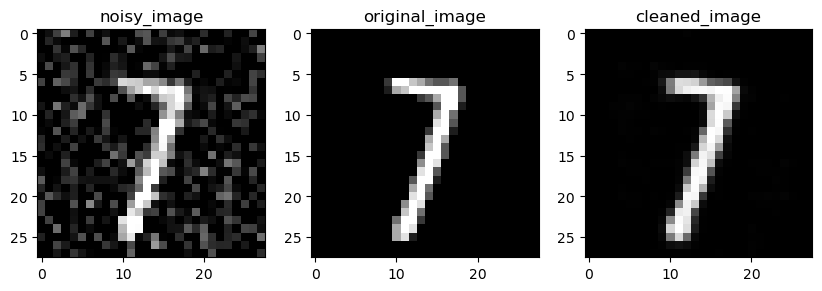

In [53]:
model.eval()

with torch.no_grad():
    dataiter=iter(trainloader)
    sample=dataiter.next()
    
    noisy_img, org_img=sample #one batch = 16
    
    index=15
    
    print(noisy_img.shape)
    cleaned_img=model(noisy_img[index].unsqueeze(0)) 
    #noisy img shape is (c,h,w)
    #in order to (batchsize, c, h,w), unsqueeze
    
    print(cleaned_img.shape)
    print(cleaned_img.squeeze(0).shape)
    
    show_image(noisy_img[index], org_img[index], cleaned_img.squeeze(0))